In [25]:
!curl -o 'weather-2016.html' \
    -d 'messw_beg=01.01.2016&messw_end=31.12.2016&felder[]=Temp2m&auswahl=2&combilog=mythenquai&suchen=Werte anzeigen' \
    -e 'https://www.tecson-data.ch/zurich/mythenquai/index.php' \
    -X POST 'https://www.tecson-data.ch/zurich/mythenquai/uebersicht/messwerte.php'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.0M    0 13.0M  100   109  8741k     71  0:00:01  0:00:01 --:--:-- 8746k


In [47]:
%matplotlib inline
import pandas as pd

In [41]:
df = pd.read_html(open('weather-2016.html', encoding='iso-8859-1'),
                  attrs={'border': '1'},
                  skiprows=1, parse_dates=True, index_col=0)
df = df[0]

In [45]:
df.columns = ['Temp']
df.head()

,Temp
0,
2016-01-01 00:00:00,6.3
2016-01-01 00:10:00,6.3
2016-01-01 00:20:00,6.3
2016-01-01 00:30:00,6.4
2016-01-01 00:40:00,6.4


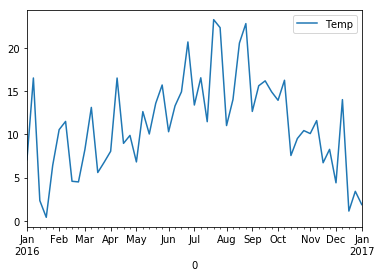

In [60]:
df.resample('W').mean().plot()

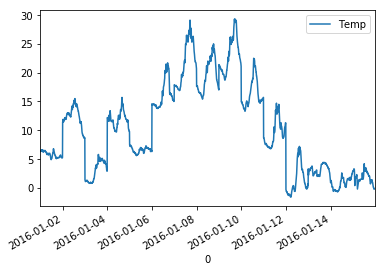

In [68]:
df[:"01/15/2016"].plot()

Something is not right ...

In [76]:
pd.to_datetime('01.08.2016 00:00:00')

Timestamp('2016-08-01 00:00:00')

In [76]:
pd.to_datetime('01.08.2016 00:00:00', dayfirst=True)

Timestamp('2016-08-01 00:00:00')

## Attempt two

We load the data without trying to parse the dates automatically. Instead we specify explicitly the format (day first) when we convert the first column to a datetime.

In [70]:
df = pd.read_html(open('weather-2016.html', encoding='iso-8859-1'),
                  attrs={'border': '1'},
                  skiprows=1)
df = df[0]

In [79]:
df[0] = pd.to_datetime(df[0], dayfirst=True)

In [83]:
df.columns = ['Date', 'Temp']
df = df.set_index('Date')

In [84]:
df.head(5)

,Temp
Date,
2016-01-01 00:00:00,6.3
2016-01-01 00:10:00,6.3
2016-01-01 00:20:00,6.3
2016-01-01 00:30:00,6.4
2016-01-01 00:40:00,6.4


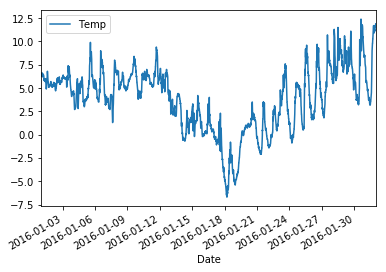

In [98]:
df[:"20160131"].plot()

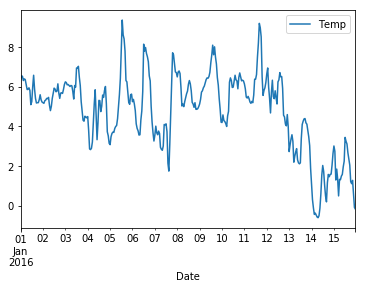

In [97]:
df['20160101':'20160115'].resample('H').mean().plot();

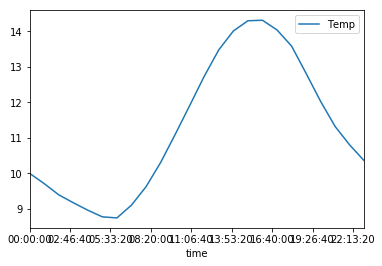

In [59]:
hourly = df.resample('H').mean()
hourly.groupby(hourly.index.time).mean().plot();